In [1]:
from gensim import corpora, models
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.snowball import EnglishStemmer

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from src.preprocessing import *
from src.feature_reduction import *
from src.classifiers import *
from src.plots import *
from src.CV import *

import time
import gc
import os
import gc
import psutil


import pandas as pd
import matplotlib as mpl
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as prepro
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
random_state=0
proc = psutil.Process(os.getpid())
mem0 = proc.memory_info().rss
print(mem0)

144441344


PARAMETERS:

In [3]:
summary_weight=2
negation_distance_threshold_review=2
negation_distance_threshold_summary=4
sample_size=5000
save_location='output_figs2'

# Step 1

## Data loading

In [4]:
df = pd.read_json(path_or_buf='amazon_step23.json',orient='records',lines=True)

In [5]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,5555991584,"[3, 3]",5,"It's hard to believe ""Memory of Trees"" came ou...","09 12, 2006",A3EBHHCZO6V2A4,"Amaranth ""music fan""",Enya's last great album,1158019200
1,5555991584,"[0, 0]",5,"A clasically-styled and introverted album, Mem...","06 3, 2001",AZPWAXJG9OJXV,bethtexas,Enya at her most elegant,991526400
2,5555991584,"[2, 2]",5,I never thought Enya would reach the sublime h...,"07 14, 2003",A38IRL0X2T4DPF,bob turnley,The best so far,1058140800
3,5555991584,"[1, 1]",5,This is the third review of an irish album I w...,"05 3, 2000",A22IK3I6U76GX0,Calle,Ireland produces good music.,957312000
4,5555991584,"[1, 1]",4,"Enya, despite being a successful recording art...","01 17, 2008",A1AISPOIIHTHXX,"Cloud ""...""",4.5; music to dream to,1200528000


In [6]:
# TODO remove sampling
# Sampling to minimze computing cost
df = df.sample(sample_size,random_state=random_state)
#df.head()

## Vectorizing the review text

In [7]:
# create a corpus class with an iterator that reads one corpus document per line without loading all into memory
from gensim import corpora
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
import enchant

eng_dic = enchant.Dict("en_US")
tester = 1
lemmatizer = WordNetLemmatizer()
documents = np.array(df['reviewText'])

#print ('original: ',documents[tester], '\n')

# TODO use the stopwords file ? should ask fayez

negativeword_file=open('negative_words.txt')
NEGATIVEWORDS=negativeword_file.read().split()

positiveword_file=open('positive_words.txt')
POSITIVEWORDS=positiveword_file.read().split()

negationword_file=open('negation_words.txt')
NEGATIONWORDS=negationword_file.read().split()

# Not Merging both reviewText and summary because summary is more important
#documents = df[['reviewText', 'summary']].apply(lambda x: ''.join(x), axis=1)
documents=np.array(df['reviewText'])
summaries=np.array(df['summary'])

print ('original test: ',documents[tester], '\n')
print ('summary test: ',summaries[tester], '\n')

original test:  This is the bottom line: If you like New-Wave/Electronic music of the early eighties and you had no idea who A Flock Of Seagulls were or had no way of associating them with the way they looked or their MTV status, then you would like this album. A very undderrated band for sure, this album is awesome especially for (It's Not Me) Talking, Wishing, Nightmares, and The Traveller. I'll admit the bonus B-Sides arent the greatest but the live version of I Ran is excellent and the orginal album holds up very well. I dont think its my absolute favorite but it ties with their first album( DNA and Messages are two of my favs). The guitar and keyboard sound so good together it really creates a timeless feel, even for a New Wave band. This album speaks for itsself(and its era). Do as the album title implies...good cd. Nuff said 

summary test:  Still cool to listen to 



In [8]:
#Remove special characters
documents_no_specials=remove_specials_characters(documents)
# remove stop words and tokenize
documents_no_stop= []
for document in documents_no_specials:
    new_text=[]
    for word in document.lower().split():
        if word not in STOPWORDS:
            new_text.append(word)
    documents_no_stop.append(new_text)
    
#print ('tokenize and remove stop words: ',documents_no_stop[tester], '\n')

#Remove special characters
summaries_no_specials=remove_specials_characters(summaries)
# remove stop words and tokenize
summaries_no_stop= []
for document in summaries_no_specials:
    new_text=[]
    for word in document.lower().split():
        if word not in STOPWORDS:
            new_text.append(word)
    summaries_no_stop.append(new_text)
    
#print ('tokenize and remove stop words: ',documents_no_stop[tester], '\n')

In [9]:

documents_no_stop_no_numeric = remove_numerical(documents_no_stop)
summaries_no_stop_no_numeric = remove_numerical(summaries_no_stop)
#print ('remove numerics: ',documents_no_stop_no_numeric[tester], '\n')


In [10]:
# lemmattizing tokens (better than stemming by taking word context into account)

documents_no_stop_no_numeric_lemmatize = [[lemmatizer.lemmatize(token) for token in text] 
                                                    for text in documents_no_stop_no_numeric]
summaries_no_stop_no_numeric_lemmatize = [[lemmatizer.lemmatize(token) for token in text] 
                                                    for text in summaries_no_stop_no_numeric]

#print ('lemmatize: ',documents_no_stop_no_numeric_lemmatize[tester], '\n')

In [11]:

# remove non-english words

documents_no_stop_no_numeric_lemmatize_english = [[token for token in text if (eng_dic.check(token)) ] 
                                                            for text in documents_no_stop_no_numeric_lemmatize]

print ('no english: ',documents_no_stop_no_numeric_lemmatize_english[tester], '\n')

summaries_no_stop_no_numeric_lemmatize_english = [[token for token in text if (eng_dic.check(token)) ] 
                                                            for text in summaries_no_stop_no_numeric_lemmatize]

print ('no english: ',summaries_no_stop_no_numeric_lemmatize_english[tester], '\n')

no english:  ['line', 'like', 'new', 'wave', 'electronic', 'music', 'early', 'eighty', 'idea', 'flock', 'seagull', 'way', 'associating', 'way', 'looked', 'status', 'like', 'album', 'band', 'sure', 'album', 'awesome', 'especially', 'talking', 'wishing', 'nightmare', 'ill', 'admit', 'bonus', 'b', 'side', 'greatest', 'live', 'version', 'ran', 'excellent', 'album', 'hold', 'think', 'absolute', 'favorite', 'tie', 'album', 'message', 'guitar', 'keyboard', 'sound', 'good', 'creates', 'timeless', 'feel', 'new', 'wave', 'band', 'album', 'speaks', 'era', 'album', 'title', 'implies', 'good', 'said'] 

no english:  ['cool', 'listen'] 



In [12]:
# create ready corpus

df['reviewCleaned'] = [" ".join(doc) for doc in documents_no_stop_no_numeric_lemmatize_english] 
df['summaryCleaned'] = [" ".join(doc) for doc in summaries_no_stop_no_numeric_lemmatize_english] 

#df['reviewCleaned']

In [13]:
def keepAdjectives(documents,NEGATIONWORDS, POSITIVEWORDS, NEGATIVEWORDS,negation_distance_threshold):
    
    document_neg_pos = []
    document_neg_count = np.zeros(df.shape[0])
    document_pos_count = np.zeros(df.shape[0])

    for idx,row in enumerate(documents):
        review = []
        new_word = ""
        negation_distance=0
        
        for word in row.split(" "):
            if len(new_word) != 1:
                negation_distance+=1
                if negation_distance>negation_distance_threshold:
                    new_word=""
            if word in NEGATIONWORDS:
                new_word = word
                negation_distance=0
            elif word in POSITIVEWORDS:
                if len(new_word)==0:
                    review.append(word)
                    document_pos_count[idx]+=1
                else:
                    #print(idx)
                    document_neg_count[idx]+=1
                    new_word = new_word + word
                    review.append(new_word)
                    new_word = ""
            elif word in NEGATIVEWORDS:
                if len(new_word)==0:
                    review.append(word)
                    document_neg_count[idx]+=1
                else:
                    #print(idx)
                    document_pos_count[idx]+=1
                    new_word = new_word + word
                    review.append(new_word)
                    new_word = ""
        document_neg_pos.append(review)
    return document_neg_pos, document_pos_count, document_neg_count

# Not sure if ratio of counts is relevent since someone who like average
# the product a juste write 'good...' would get an extremely high ratio
documents_neg_pos, documents_pos_count, documents_neg_count = keepAdjectives(
    df['reviewCleaned'],NEGATIONWORDS,POSITIVEWORDS,NEGATIVEWORDS,negation_distance_threshold_review)
print("Kept only adjectives pairs:",documents_neg_pos[tester], 
      '\nPositive count=',documents_pos_count[tester],'Negative counts=',documents_neg_count[tester])

summaries_neg_pos, summaries_pos_count, summaries_neg_count = keepAdjectives(
    df['summaryCleaned'],NEGATIONWORDS,POSITIVEWORDS,NEGATIVEWORDS,negation_distance_threshold_summary)
print("Kept only adjectives pairs:",summaries_neg_pos[tester], 
      '\nPositive count=',summaries_pos_count[tester],'Negative counts=',summaries_neg_count[tester])


Kept only adjectives pairs: ['like', 'like', 'awesome', 'nightmare', 'bonus', 'greatest', 'excellent', 'favorite', 'good', 'good'] 
Positive count= 9.0 Negative counts= 1.0
Kept only adjectives pairs: ['cool'] 
Positive count= 1.0 Negative counts= 0.0


In [14]:
print ('original text: ',documents[373], '\n')
print ('no english: ',documents_no_stop_no_numeric_lemmatize_english[373], '\n')
print("Kept only adjectives pairs:",documents_neg_pos[373], 
      '\nPositive count=',documents_pos_count[373],'Negative counts=',documents_neg_count[373])
print ('original text: ',summaries[373], '\n')
print ('no english: ',summaries_no_stop_no_numeric_lemmatize_english[373], '\n')
print("Kept only adjectives pairs:",summaries_neg_pos[373],
      '\nPositive count=',summaries_pos_count[373],'Negative counts=',summaries_neg_count[373])

original text:  Busta Rhymes in 98 came out with what i felt was the most  creative album of his career  ELE is back with another slamming CD  while Anarchy may not be as innovative as  ELE was this CD still  is blazing..  Busta's  flows  are tight as ever.. Production is on  point with  long time producer DJ.  Scratch who has been down since Busta's solo debut The Coming.. DJ Scratch  deliver such  bangers on  Busta's new CD  Salute Da Goods,  We Comin  Through which  he takes a page out of Swizz Beatz book of beats .. This  track sounds like something Swizz Beatz would have done  ..  One of the  best cuts on the album  .. Producer Jay Dee brings a raw banging sound to  tracks  Enjoy Da Ride, Live It Up,  Show Me What You Got For Me all these  tracks mention are hot .. The best cut on the album clearly is The Heist  featuring Raekwon, Ghostface Killa, Flip Mode's newest member Roc-Marciano  this track is worth the price of CD alone  the song depict  jewerly robbery  gone bad.. Other n

In [15]:
df["reviewWorded"] = [" ".join(doc) for doc in documents_neg_pos]
df["summaryWorded"] = [" ".join(doc) for doc in summaries_neg_pos]
df['review_count_pos'] = documents_pos_count
df['review_count_neg'] = documents_neg_count
df['summary_count_pos'] = summaries_pos_count
df['summary_count_neg'] = summaries_neg_count
# Not sure if ratio of counts is relevent since someone who like average
# the product a juste write 'good...' would get an extremely high ratio.
# However, the difference between the two could be interesting
df['review_count_difference']=df['review_count_pos']-df['review_count_neg']
df['summary_count_difference']=df['summary_count_pos']-df['summary_count_neg']
df['total_count_difference']=df['review_count_difference']+summary_weight*df['summary_count_difference']
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,reviewCleaned,summaryCleaned,reviewWorded,summaryWorded,review_count_pos,review_count_neg,summary_count_pos,summary_count_neg,review_count_difference,summary_count_difference,total_count_difference
18091,B000002NBY,"[0, 0]",5,"I have given other albums five stars, but ""Gra...","08 3, 2002",A2VBI34EIGLG9C,Emily,Amazing Album--TRUELY Merits 5 Stars,1028332800,given album star simply exceeds rating slightl...,amazing album merit star,exceeds miraculous powerful distinctive master...,amazing merit,79.0,14.0,2.0,0.0,65.0,2.0,69.0
47316,B0002ZDW80,"[3, 3]",4,This is the bottom line: If you like New-Wave/...,"11 1, 2004",A9IZ4H60VZMMT,Herbert West,Still cool to listen to,1099267200,line like new wave electronic music early eigh...,cool listen,like like awesome nightmare bonus greatest exc...,cool,9.0,1.0,1.0,0.0,8.0,1.0,10.0
44199,B0000DD79B,"[2, 87]",1,"Great, just what we need. A 2-album disc set ...","10 30, 2003",A1NVEW628JUS2Y,Da Peace Dogg,Hippies are gonna love this one,1067472000,great need album disc set feature overrated in...,gonna love,great overrated annoying break jealous boring ...,love,5.0,11.0,1.0,0.0,-6.0,1.0,-4.0
44398,B0000DFZZA,"[9, 9]",4,Upon hearing ''I'm Like A Bird'' for the very ...,"03 21, 2004",A1SJ1GPWF60GU0,"MJ ""MJ""",No One Trick Pony In My Book,1079827200,hearing like bird time instantly took dislike ...,trick pony book,like instantly dislike simplistic darling whoa...,trick,40.0,13.0,0.0,1.0,27.0,-1.0,25.0
18616,B000002O6A,"[0, 2]",4,"I have known about ""Lizard"" since its release ...","08 23, 2007",A21VBTSS7MSSMO,"John Marshall Lancaster ""Buffett fan""",Good Disc,1187827200,known lizard release adding collection best wa...,good disc,best great pleasantly pleased worth unjustly like,good,6.0,1.0,1.0,0.0,5.0,1.0,7.0


In [17]:
# REMOVE DF_min and df _ max
vectorizer = CountVectorizer()
# vectorizer = TfidfVectorizer() We don't need to reduce the importance of words that appear often since they are already filtered

# fit vectorizer, carry out vectorization and display results
vectorizer.fit(df[['reviewWorded', 'summaryWorded']].apply(lambda x: ''.join(x), axis=1))   # TODO join with df[['reviewText', 'summary']].apply(lambda x: ''.join(x), axis=1)
documents_vec = vectorizer.transform(df['reviewWorded'])
summaries_vec = vectorizer.transform(df['summaryWorded'])
summaries_vec*=summary_weight
documents_vec+=summaries_vec
#print(documents_vec) # sparse matrix representation

In [18]:
print(documents_vec)

  (0, 3356)	1.72574755945
  (0, 58)	0.0951873896963
  (0, 109)	1.06352170397
  (0, 118)	0.0881016758555
  (0, 230)	0.191809755792
  (0, 310)	0.0982782265349
  (0, 328)	0.0686069188496
  (0, 347)	0.0894600801219
  (0, 626)	0.0612566546225
  (0, 637)	0.083030592699
  (0, 700)	0.0540261172294
  (0, 711)	0.190374779393
  (0, 819)	0.0644339401528
  (0, 825)	0.0713802634617
  (0, 892)	0.119572613599
  (0, 906)	0.109379474649
  (0, 953)	0.0889931967493
  (0, 1005)	0.0691928764843
  (0, 1081)	0.0597981493986
  (0, 1367)	0.258252156827
  (0, 1652)	0.111343132696
  (0, 1686)	0.079996293504
  (0, 1694)	0.116291155796
  (0, 1703)	0.123803148498
  (0, 1717)	0.102239795276
  :	:
  (4995, 672)	0.354445232267
  (4995, 1682)	0.292727042219
  (4995, 2067)	0.543350105522
  (4995, 2152)	0.100053359091
  (4995, 2563)	0.199741068613
  (4995, 3106)	0.278078287512
  (4995, 4058)	0.208817973679
  (4995, 4996)	0.248168674007
  (4995, 5087)	0.295418786647
  (4996, 2252)	0.384666677816
  (4996, 2412)	0.8673201477

In [19]:
# Cleaning memory

proc = psutil.Process(os.getpid())
mem1 = proc.memory_info().rss
del lemmatizer, document,documents,documents_no_specials,documents_no_stop,documents_no_stop_no_numeric
del documents_no_stop_no_numeric_lemmatize,documents_no_stop_no_numeric_lemmatize_english, eng_dic
del  summaries,summaries_no_specials,summaries_no_stop,summaries_no_stop_no_numeric
del summaries_no_stop_no_numeric_lemmatize,summaries_no_stop_no_numeric_lemmatize_english
mem2 = proc.memory_info().rss
gc.collect()
mem3 = proc.memory_info().rss
pd = lambda x2, x1: 100.0 * (x2 - x1) / mem0
print ("Allocation: %0.2f%%" % pd(mem1, mem0))
print ("Unreference: %0.2f%%" % pd(mem2, mem1))
print ("Collect: %0.2f%%" % pd(mem3, mem2))
print ("Overall: %0.2f%%" % pd(mem3, mem0))




Allocation: 225.33%
Unreference: -3.23%
Collect: 0.00%
Overall: 222.11%


## Category Prediction 

### Pre-Processing

X is the review word vector. y are the corresponding categories.

The data is Min/max scaled into [0;1]. It isn't standartize because we want positive values. One could try a normalization (l1 or l2 for example)

We split the data into a train and test set. 

tf/idf is not relevant since words that appear often might suggest a category (such as 'book')

In [26]:
from scipy.sparse import hstack,csr_matrix
y=np.where(df['overall']==5,1,0)
print(y.shape)

ranks=np.unique(y)
X_scaled=preprocessing.normalize(documents_vec,norm='max', copy=False)
#X_scaled=documents_vec
#X=df[['total_count_difference','review_count_pos','review_count_neg','summary_count_pos','summary_count_neg']]

proc.memory_info().rss

from scipy.sparse import hstack,csr_matrix
count_diff = csr_matrix(df['total_count_difference']).T
count_pos_rev = csr_matrix(df['review_count_pos']).T
count_neg_rev = csr_matrix(df['review_count_neg']).T
count_pos_sum = csr_matrix(df['summary_count_pos']).T
count_neg_sum = csr_matrix(df['summary_count_neg']).T

hstack([count_neg_sum,X_scaled])
X=hstack([hstack([hstack([count_diff,count_pos_rev]),hstack([count_neg_rev,count_pos_sum])])
         ,hstack([count_neg_sum,X_scaled])])

#X=X_scaled # just words
print(X.shape)

(5000,)
(5000, 5700)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [24]:
proc.memory_info().rss

465256448

In [ ]:
# Numpy arrays
#X_train=np.array(X_train)
#X_test=np.array(X_test)
#y_train=np.array(y_train)
#y_test=np.array(y_test)

### Trying Feature selection

#### select k best

In [138]:
from sklearn.feature_selection import SelectKBest
parameter_search_feature_selection(LogisticRegression(C=0.74438, n_jobs=-1),SelectKBest(),'k',np.logspace(2,3.7,10).astype(int),
                                   X_train,y_train,random_state=random_state,save_fig=save_location+'/slt_k_best.png')

TypeError: parameter_search_feature_selection() got an unexpected keyword argument 'save_fig'

#### Latent Semantic Indexing

In [55]:
X_train_concepts,X_test_concepts = LSI_concepts(X_train,X_test,num_lsi_topics = 100,words=vectorizer.get_feature_names())

In [82]:
start = time.time()

y_pred=cosine_pred(X_train_concepts,X_test_concepts,y_train,categories)
print("accuracy:",accuracy_score(y_test,y_pred))

end=time.time()
print("Execution time : {} seconds".format(end-start))

0
100
200
300
400
500
600
700
800
900
accuracy: 0.417
Execution time : 15.908146142959595 seconds


25
0
100
200
300
400
500
600
700
800
900
accuracy: 0.297
30
0
100
200
300
400
500
600
700
800
900
accuracy: 0.298
35
0
100
200
300
400
500
600
700
800
900
accuracy: 0.31
40
0
100
200
300
400
500
600
700
800
900
accuracy: 0.323
50
0
100
200
300
400
500
600
700
800
900
accuracy: 0.345
60
0
100
200
300
400
500
600
700
800
900
accuracy: 0.376
70
0
100
200
300
400
500
600
700
800
900
accuracy: 0.385
80
0
100
200
300
400
500
600
700
800
900
accuracy: 0.393
90
0
100
200
300
400
500
600
700
800
900
accuracy: 0.424
100
0
100
200
300
400
500
600
700
800
900
accuracy: 0.424
200
0
100
200
300
400
500
600
700
800
900
accuracy: 0.465
300
0
100
200
300
400
500
600
700
800
900
accuracy: 0.477
400
0
100
200
300
400
500
600
700
800
900
accuracy: 0.489
500
0
100
200
300
400
500
600
700
800
900
accuracy: 0.494
600
0
100
200
300
400
500
600
700
800
900
accuracy: 0.501
700
0
100
200
300
400
500
600
700
800
900
accuracy: 0.502
800
0
100
200
300
400
500
600
700
800
900
accuracy: 0.502
900
0
100
200
300
400
50

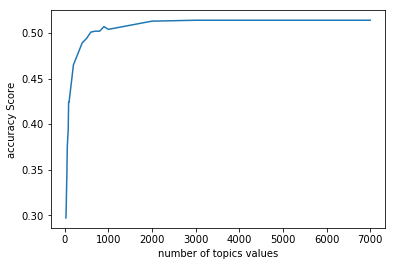

Execution time : 3555.529062271118 seconds
best num_lsi_topics= 3000 with accuracy score: 0.514


In [83]:
start=time.time()

accuracy=[]
num_lsi_topics_array = [25,30,35,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000,2000,3000,4000,5000,6000,7000]
# Check various C
for num_lsi_topics in num_lsi_topics_array:
    print(num_lsi_topics)
    # fit classifier 
    X_train_concepts,X_test_concepts = LSI_concepts(X_train,X_test,num_lsi_topics,words=vectorizer.get_feature_names())
    
    y_pred=cosine_pred(X_train_concepts,X_test_concepts,y_train, categories)
    print("accuracy:",accuracy_score(y_test,y_pred))
    accuracy.append(accuracy_score(y_test,y_pred))

# Plot
plt.plot(num_lsi_topics_array,accuracy)
plt.ylabel("accuracy Score")
plt.xlabel("number of topics values")
plt.show()

end=time.time()
print("Execution time : {} seconds".format(end-start))
best_c=num_lsi_topics_array[np.argmax(accuracy)]
print("best num_lsi_topics=",best_c,"with accuracy score:", np.max(accuracy))

#### Latent Dirichlet Allocation LDA

In [59]:
# USE LSI number of concepts and then tune update every and passes
start = time.time()
X_train_concepts,X_test_concepts = LDA_concepts(X_train,X_test,num_lda_topics = 100,words=vectorizer.get_feature_names())
y_pred=cosine_pred(X_train_concepts,X_test_concepts,y_train,categories)
print("accuracy:",accuracy_score(y_test,y_pred))

end=time.time()
print("Execution time : {} seconds".format(end-start))

KeyboardInterrupt: 

In [ ]:
start=time.time()

accuracy=[]
num_lda_topics_array = [25,30,35,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000,2000,3000,4000,5000,6000,7000]
# Check various C
for num_lda_topics in num_lda_topics_array:
    print(num_lda_topics)
    # fit classifier 
    X_train_concepts,X_test_concepts = LDA_concepts(X_train,X_test,num_lsi_topics,words=vectorizer.get_feature_names())
    
    y_pred=cosine_pred(X_train_concepts,X_test_concepts,y_train, categories)
    print("accuracy:",accuracy_score(y_test,y_pred))
    accuracy.append(accuracy_score(y_test,y_pred))

# Plot
plt.plot(num_lda_topics_array,accuracy)
plt.ylabel("accuracy Score")
plt.xlabel("Number of topics values")
plt.show()

end=time.time()
print("Execution time : {} seconds".format(end-start))
best_c=num_lsi_topics_array[np.argmax(accuracy)]
print("best num_lsi_topics=",best_c,"with accuracy score:", np.max(accuracy))

### Classifying

#### dummy classifier

Baseline model: Assign the categories randomly.

In [63]:
from sklearn.dummy import DummyClassifier
dmy=DummyClassifier(random_state=random_state)
dmy.fit(X_train,y_train)
y_pred=dmy.predict(X_test)
print("accuracy:",accuracy_score(y_test,y_pred))

accuracy: 0.516


#### Cosine similarity

For each category  we regroup the documents belonging to this category together. Then for each element we want to predict, we check how similar it is compared to each group (cosine similarity). The most similar group gives the category to the element.

In [23]:

from sklearn.model_selection import cross_val_score


start= time.time()
cosine_classifier=Cosine_sim(categories)
print("Mean CV valdiation score:",np.mean(cross_val_score(
    cosine_classifier,X_train,y_train,scoring='accuracy',cv=5,verbose=2,n_jobs=-1)))
end=time.time()
print("Execution time : {} seconds".format(end-start))



[CV]  ................................................................
[CV]  ................................................................
0
[CV]  ................................................................
0
[CV]  ................................................................
0
[CV]  ................................................................
0
0
100
100
100
100
100
200
200
200
200
200
300
300
300
300
300
400
400
400
400
400
500
500
500
500
500
600
600
600
600
600
700
700
700
700
700
[CV] ................................................. , total=14.7min
[CV] ................................................. , total=14.9min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 14.9min remaining: 22.3min


[CV] ................................................. , total=14.9min
[CV] ................................................. , total=15.3min
[CV] ................................................. , total=15.3min
Mean CV valdiation score: 0.5125
Execution time : 920.8456282615662 seconds


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.3min finished


#### Decision tree

Try various maximum depths for a classic decision tree classifier

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] max_depth=1 .....................................................
[CV] max_depth=1 .....................................................
[CV] max_depth=1 .....................................................
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.0s
[CV] ...................................... max_depth=1, total=   0.0s
[CV] max_depth=1 .....................................................
[CV] max_depth=11 ....................................................
[CV] ...................................... max_depth=1, total=   0.0s
[CV] ...................................... max_depth=1, total=   0.0s
[CV] ...................................... max_depth=1, total=   0.0s
[CV] max_depth=11 ....................................................
[CV] max_depth=11 ....................................................
[CV] max_depth=

[CV] max_depth=111 ...................................................
[CV] .................................... max_depth=121, total=   0.6s
[CV] max_depth=121 ...................................................
[CV] ..................................... max_depth=91, total=   0.5s
[CV] max_depth=131 ...................................................
[CV] .................................... max_depth=111, total=   0.5s
[CV] max_depth=111 ...................................................
[CV] .................................... max_depth=111, total=   0.5s
[CV] max_depth=131 ...................................................
[CV] .................................... max_depth=131, total=   0.5s
[CV] max_depth=131 ...................................................
[CV] .................................... max_depth=121, total=   0.5s
[CV] max_depth=121 ...................................................
[CV] .................................... max_depth=111, total=   0.5s
[CV] m

[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   10.7s


[CV] .................................... max_depth=181, total=   0.5s
[CV] max_depth=191 ...................................................
[CV] .................................... max_depth=181, total=   0.5s
[CV] max_depth=191 ...................................................
[CV] .................................... max_depth=181, total=   0.5s
[CV] max_depth=191 ...................................................
[CV] .................................... max_depth=191, total=   0.5s
[CV] max_depth=191 ...................................................
[CV] .................................... max_depth=191, total=   0.5s
[CV] max_depth=201 ...................................................
[CV] .................................... max_depth=191, total=   0.4s
[CV] max_depth=201 ...................................................
[CV] .................................... max_depth=191, total=   0.5s
[CV] max_depth=201 ...................................................
[CV] .

[CV] max_depth=301 ...................................................
[CV] max_depth=301 ...................................................
[CV] .................................... max_depth=301, total=   0.5s
[CV] max_depth=311 ...................................................
[CV] .................................... max_depth=301, total=   0.6s
[CV] max_depth=311 ...................................................
[CV] .................................... max_depth=301, total=   0.6s
[CV] max_depth=311 ...................................................
[CV] .................................... max_depth=301, total=   0.6s
[CV] max_depth=311 ...................................................
[CV] .................................... max_depth=311, total=   0.4s
[CV] max_depth=311 ...................................................
[CV] .................................... max_depth=311, total=   0.4s
[CV] max_depth=321 ...................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   25.1s finished
/home/pace/Documents/data_science/project-pace-mourad/adrian/src/plots.py:30: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if train_scores_std != None and val_scores_std != None:


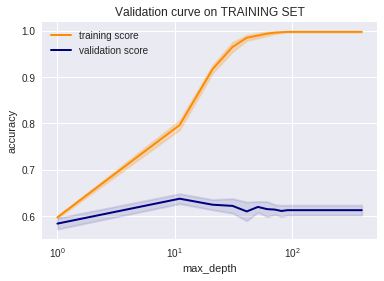

Best ['max_depth'] = {'max_depth': 11} with score : 0.6375
Execution time : 26.262213945388794 seconds


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(1, 400, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [124]:
parameter_search(DecisionTreeClassifier(random_state=random_state),
                {'max_depth':range(1,400,10)},
                X_train,
                y_train,save_file=save_location+'/decision tree.png')

#### k nearest neighbors

Fitting 5 folds for each of 17 candidates, totalling 85 fits
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   0.2s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   0.3s
[CV] .................................... n_neighbors=1, total=   0.3s
[CV] n_neighbors=7 ...................................................
[CV] .................................... n_neighbors=1, total=   0.3s
[CV] n_neighbors=7 ...................................................
[CV] n_neighbors=7 ...................................................
[CV] .................................... n_neighbors=1, total=   0.2s
[CV] n_neighbors

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.8s


[CV] ................................... n_neighbors=37, total=   0.3s
[CV] ................................... n_neighbors=37, total=   0.3s
[CV] n_neighbors=43 ..................................................
[CV] n_neighbors=43 ..................................................
[CV] ................................... n_neighbors=43, total=   0.3s
[CV] n_neighbors=43 ..................................................
[CV] ................................... n_neighbors=43, total=   0.3s
[CV] n_neighbors=49 ..................................................
[CV] ................................... n_neighbors=43, total=   0.2s
[CV] n_neighbors=49 ..................................................
[CV] ................................... n_neighbors=43, total=   0.3s
[CV] ................................... n_neighbors=43, total=   0.2s
[CV] n_neighbors=49 ..................................................
[CV] n_neighbors=49 ..................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   37.6s finished
/home/pace/Documents/data_science/project-pace-mourad/adrian/src/plots.py:30: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if train_scores_std != None and val_scores_std != None:


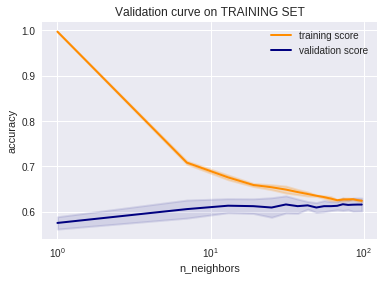

Best ['n_neighbors'] = {'n_neighbors': 73} with score : 0.6165
Execution time : 38.71186423301697 seconds


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': range(1, 100, 6)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [125]:
from sklearn.neighbors import KNeighborsClassifier

parameter_search(KNeighborsClassifier(),
                {'n_neighbors':range(1,100,6)},
                X_train,
                y_train,save_file=save_location+'/knn.png')


#### SVM

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] C=1e-05 .........................................................
[CV] C=1e-05 .........................................................
[CV] C=1e-05 .........................................................
[CV] C=1e-05 .........................................................
[CV] .......................................... C=1e-05, total=   4.1s
[CV] C=1e-05 .........................................................
[CV] .......................................... C=1e-05, total=   4.6s
[CV] C=5.17947467923e-05 .............................................
[CV] .......................................... C=1e-05, total=   4.5s
[CV] C=5.17947467923e-05 .............................................
[CV] .......................................... C=1e-05, total=   4.7s
[CV] C=5.17947467923e-05 .............................................
[CV] .......................................... C=1e-05, total=   4.0s
[CV] C=5.1794746

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min


[CV] ................................. C=0.193069772888, total=   3.5s
[CV] C=1.0 ...........................................................
[CV] ............................................ C=1.0, total=   3.4s
[CV] C=1.0 ...........................................................
[CV] ................................. C=0.193069772888, total=   3.5s
[CV] C=1.0 ...........................................................
[CV] ............................................ C=1.0, total=   3.2s
[CV] C=5.17947467923 .................................................
[CV] ............................................ C=1.0, total=   3.4s
[CV] C=5.17947467923 .................................................
[CV] ............................................ C=1.0, total=   3.3s
[CV] C=5.17947467923 .................................................
[CV] ............................................ C=1.0, total=   3.7s
[CV] C=5.17947467923 .................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  3.3min finished
/home/pace/Documents/data_science/project-pace-mourad/adrian/src/plots.py:30: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if train_scores_std != None and val_scores_std != None:


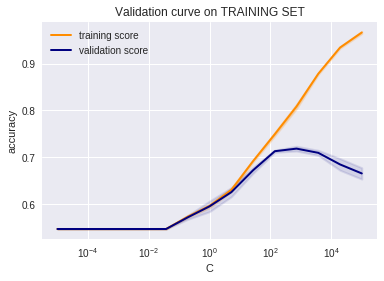

Best ['C'] = {'C': 719.68567300115285} with score : 0.7185
Execution time : 204.3917272090912 seconds


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-05,   5.17947e-05,   2.68270e-04,   1.38950e-03,
         7.19686e-03,   3.72759e-02,   1.93070e-01,   1.00000e+00,
         5.17947e+00,   2.68270e+01,   1.38950e+02,   7.19686e+02,
         3.72759e+03,   1.93070e+04,   1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [142]:
parameter_search(SVC(),
                {'C':np.logspace(-5,5,15)},
                X_train,
                y_train,save_file=save_location+'/svm.png')

#### Logistic classifier

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] C=1e-05 .........................................................
[CV] C=1e-05 .........................................................
[CV] C=1e-05 .........................................................
[CV] C=1e-05 .........................................................
[CV] .......................................... C=1e-05, total=   0.1s
[CV] .......................................... C=1e-05, total=   0.1s
[CV] .......................................... C=1e-05, total=   0.1s
[CV] .......................................... C=1e-05, total=   0.1s
[CV] C=1e-05 .........................................................
[CV] C=1.80472176683e-05 .............................................
[CV] C=1.80472176683e-05 .............................................
[CV] C=1.80472176683e-05 .............................................
[CV] .............................. C=1.80472176683e-05, total=   0.0s
[CV] C=1.804721

[CV] ............................... C=0.00661474064123, total=   0.1s
[CV] C=0.00661474064123 ..............................................
[CV] C=0.0119377664171 ...............................................
[CV] ................................ C=0.0119377664171, total=   0.1s
[CV] ............................... C=0.00661474064123, total=   0.1s
[CV] C=0.0119377664171 ...............................................
[CV] C=0.0215443469003 ...............................................
[CV] ................................ C=0.0119377664171, total=   0.1s
[CV] C=0.0215443469003 ...............................................
[CV] ............................... C=0.00661474064123, total=   0.1s
[CV] C=0.00661474064123 ..............................................
[CV] ................................ C=0.0119377664171, total=   0.1s
[CV] C=0.0119377664171 ...............................................
[CV] ................................ C=0.0215443469003, total=   0.1s
[CV] C

[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    3.0s


[CV] ................................. C=0.744380301325, total=   0.2s
[CV] C=0.744380301325 ................................................
[CV] ................................... C=1.3433993326, total=   0.3s
[CV] C=1.3433993326 ..................................................
[CV] ................................... C=1.3433993326, total=   0.3s
[CV] C=2.42446201708 .................................................
[CV] ................................. C=0.744380301325, total=   0.3s
[CV] C=2.42446201708 .................................................
[CV] ................................. C=0.744380301325, total=   0.3s
[CV] C=0.744380301325 ................................................
[CV] .................................. C=2.42446201708, total=   0.3s
[CV] C=2.42446201708 .................................................
[CV] ................................... C=1.3433993326, total=   0.4s
[CV] C=1.3433993326 ..................................................
[CV] .

[CV] .................................. C=492.388263171, total=   1.6s
[CV] C=888.623816274 .................................................
[CV] .................................. C=888.623816274, total=   1.5s
[CV] C=888.623816274 .................................................
[CV] .................................. C=888.623816274, total=   1.8s
[CV] C=1603.71874375 .................................................
[CV] .................................. C=888.623816274, total=   2.4s
[CV] C=1603.71874375 .................................................
[CV] .................................. C=888.623816274, total=   2.1s
[CV] C=1603.71874375 .................................................
[CV] .................................. C=888.623816274, total=   2.7s
[CV] C=1603.71874375 .................................................
[CV] .................................. C=1603.71874375, total=   2.1s
[CV] C=1603.71874375 .................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   52.7s finished
/home/pace/Documents/data_science/project-pace-mourad/adrian/src/plots.py:30: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if train_scores_std != None and val_scores_std != None:


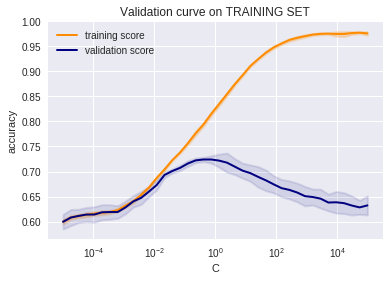

Best ['C'] = {'C': 0.4124626382901348} with score : 0.724
Execution time : 54.020185470581055 seconds


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-05,   1.80472e-05,   3.25702e-05,   5.87802e-05,
         1.06082e-04,   1.91448e-04,   3.45511e-04,   6.23551e-04,
         1.12534e-03,   2.03092e-03,   3.66524e-03,   6.61474e-03,
         1.19378e-02,   2.15443e-02,   3.88816e-02,   7.01704e-02,
         1.2663...,   5.22335e+03,   9.42668e+03,
         1.70125e+04,   3.07029e+04,   5.54102e+04,   1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [139]:
parameter_search(LogisticRegression(),
                {'C':np.logspace(-5,5,40)},
                X_train,
                y_train, save_file=save_location+'/log_reg.png')

5000, just counts : Best ['C'] = {'C': 0.0020309176209047349} with score : 0.61625
Execution time : 3.594806671142578 seconds


ALL FEATURES 5000 Best ['C'] = {'C': 0.4124626382901348} with score : 0.724
Execution time : 63.45723795890808 seconds
Out[123]:


only words 5000 Best ['C'] = {'C': 0.74438030132516808} with score : 0.7225
Execution time : 32.86425304412842 seconds

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV] C=0.05 ..........................................................
[CV] C=0.05 ..........................................................
[CV] C=0.05 ..........................................................
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.05, total=   0.2s
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.05, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ........................................... C=0.05, total=   0.3s
[CV] ........................................... C=0.05, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] ........................................... C=0.05, total=   0.2s
[CV] ..........

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.1s


[CV] ............................................ C=0.4, total=   0.3s
[CV] C=0.4 ...........................................................
[CV] ............................................ C=0.4, total=   0.2s
[CV] ............................................ C=0.4, total=   0.3s
[CV] C=0.45 ..........................................................
[CV] C=0.45 ..........................................................
[CV] ............................................ C=0.4, total=   0.3s
[CV] C=0.45 ..........................................................
[CV] ............................................ C=0.4, total=   0.2s
[CV] C=0.45 ..........................................................
[CV] ........................................... C=0.45, total=   0.2s
[CV] C=0.45 ..........................................................
[CV] ........................................... C=0.45, total=   0.3s
[CV] C=0.5 ...........................................................
[CV] .

[CV] ........................................... C=0.95, total=   0.2s
[CV] C=1.0 ...........................................................
[CV] ........................................... C=0.95, total=   0.3s
[CV] C=1.0 ...........................................................
[CV] ............................................ C=1.0, total=   0.4s
[CV] ............................................ C=1.0, total=   0.3s
[CV] C=1.0 ...........................................................
[CV] C=1.05 ..........................................................
[CV] ............................................ C=1.0, total=   0.3s
[CV] C=1.05 ..........................................................
[CV] ............................................ C=1.0, total=   0.2s
[CV] C=1.05 ..........................................................
[CV] ............................................ C=1.0, total=   0.3s
[CV] C=1.05 ..........................................................
[CV] .

[CV] ........................................... C=1.55, total=   0.4s
[CV] C=1.6 ...........................................................
[CV] ........................................... C=1.55, total=   0.2s
[CV] C=1.6 ...........................................................
[CV] ........................................... C=1.55, total=   0.3s
[CV] C=1.6 ...........................................................
[CV] ............................................ C=1.6, total=   0.2s
[CV] C=1.6 ...........................................................
[CV] ........................................... C=1.55, total=   0.3s
[CV] C=1.6 ...........................................................


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s


[CV] ............................................ C=1.6, total=   0.3s
[CV] ............................................ C=1.6, total=   0.3s
[CV] C=1.65 ..........................................................
[CV] C=1.65 ..........................................................
[CV] ............................................ C=1.6, total=   0.3s
[CV] C=1.65 ..........................................................
[CV] ............................................ C=1.6, total=   0.3s
[CV] C=1.65 ..........................................................
[CV] ........................................... C=1.65, total=   0.2s
[CV] C=1.65 ..........................................................
[CV] ........................................... C=1.65, total=   0.3s
[CV] C=1.7 ...........................................................
[CV] ........................................... C=1.65, total=   0.2s
[CV] C=1.7 ...........................................................
[CV] .

[CV] ........................................... C=2.15, total=   0.3s
[CV] C=2.2 ...........................................................
[CV] ............................................ C=2.2, total=   0.3s
[CV] C=2.2 ...........................................................
[CV] ............................................ C=2.2, total=   0.5s
[CV] ............................................ C=2.2, total=   0.2s
[CV] C=2.25 ..........................................................
[CV] C=2.25 ..........................................................
[CV] ............................................ C=2.2, total=   0.4s
[CV] C=2.25 ..........................................................
[CV] ........................................... C=2.25, total=   0.4s
[CV] C=2.25 ..........................................................
[CV] ............................................ C=2.2, total=   0.5s
[CV] C=2.25 ..........................................................
[CV] .

[CV] ........................................... C=2.75, total=   0.4s
[CV] ........................................... C=2.75, total=   0.4s
[CV] C=2.8 ...........................................................
[CV] C=2.8 ...........................................................
[CV] ........................................... C=2.75, total=   0.3s
[CV] C=2.8 ...........................................................
[CV] ............................................ C=2.8, total=   0.3s
[CV] C=2.8 ...........................................................
[CV] ............................................ C=2.8, total=   0.5s
[CV] ............................................ C=2.8, total=   0.4s
[CV] C=2.85 ..........................................................
[CV] ............................................ C=2.8, total=   0.5s
[CV] C=2.85 ..........................................................
[CV] C=2.85 ..........................................................
[CV] .

[CV] ........................................... C=3.35, total=   0.4s
[CV] C=3.35 ..........................................................
[CV] ........................................... C=3.35, total=   0.5s
[CV] C=3.4 ...........................................................
[CV] ........................................... C=3.35, total=   0.8s
[CV] C=3.4 ...........................................................
[CV] ........................................... C=3.35, total=   0.8s
[CV] ............................................ C=3.4, total=   0.4s
[CV] C=3.4 ...........................................................
[CV] C=3.4 ...........................................................
[CV] ........................................... C=3.35, total=   0.5s
[CV] C=3.4 ...........................................................
[CV] ............................................ C=3.4, total=   0.6s
[CV] C=3.45 ..........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   36.1s


[CV] C=3.65 ..........................................................
[CV] ............................................ C=3.6, total=   0.8s
[CV] C=3.65 ..........................................................
[CV] ............................................ C=3.6, total=   0.6s
[CV] C=3.65 ..........................................................
[CV] ........................................... C=3.65, total=   0.7s
[CV] C=3.65 ..........................................................
[CV] ........................................... C=3.65, total=   0.5s
[CV] C=3.7 ...........................................................
[CV] ........................................... C=3.65, total=   0.9s
[CV] C=3.7 ...........................................................
[CV] ........................................... C=3.65, total=   1.0s
[CV] C=3.7 ...........................................................
[CV] ........................................... C=3.65, total=   0.8s
[CV] C

[CV] C=4.2 ...........................................................
[CV] ........................................... C=4.15, total=   0.8s
[CV] C=4.25 ..........................................................
[CV] ............................................ C=4.2, total=   0.6s
[CV] C=4.25 ..........................................................
[CV] ............................................ C=4.2, total=   0.6s
[CV] C=4.25 ..........................................................
[CV] ............................................ C=4.2, total=   0.7s
[CV] C=4.25 ..........................................................
[CV] ........................................... C=4.25, total=   0.5s
[CV] C=4.25 ..........................................................
[CV] ........................................... C=4.25, total=   0.7s
[CV] ........................................... C=4.25, total=   0.9s
[CV] C=4.3 ...........................................................
[CV] C

[CV] C=4.8 ...........................................................
[CV] ............................................ C=4.8, total=   0.4s
[CV] C=4.8 ...........................................................
[CV] ............................................ C=4.8, total=   0.5s
[CV] C=4.8 ...........................................................
[CV] ........................................... C=4.75, total=   0.6s
[CV] C=4.85 ..........................................................
[CV] ............................................ C=4.8, total=   0.6s
[CV] C=4.85 ..........................................................
[CV] ............................................ C=4.8, total=   0.6s
[CV] C=4.85 ..........................................................
[CV] ........................................... C=4.85, total=   0.7s
[CV] C=4.85 ..........................................................
[CV] ............................................ C=4.8, total=   0.8s
[CV] C

[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:  1.0min finished
/home/pace/Documents/data_science/project-pace-mourad/adrian/src/plots.py:30: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if train_scores_std != None and val_scores_std != None:


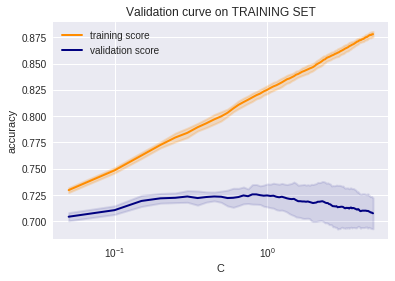

Best ['C'] = {'C': 0.80000000000000004} with score : 0.7255
Execution time : 62.313812494277954 seconds


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([ 0.05,  0.1 , ...,  4.9 ,  4.95])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [140]:
parameter_search(LogisticRegression(),
                {'C':np.arange(0.05,5,0.05)},
                X_train,
                y_train, save_file=save_location+'/log_reg_more_acc.png')

all fetures 5000 Best ['C'] = {'C': 0.80000000000000004} with score : 0.7255

only words 5000 Best ['C'] = {'C': 1.1000000000000001} with score : 0.72475
Execution time : 23.30917000770569 seconds

In [27]:
from sklearn.model_selection import cross_val_score


start= time.time()
log_reg=LogisticRegression(C=0.8)
print("Mean CV valdiation score:",np.mean(cross_val_score(
    log_reg,X_train,y_train,scoring='accuracy',cv=5,verbose=2,n_jobs=-1)))
end=time.time()
print("Execution time : {} seconds".format(end-start))


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV] ................................................. , total=   0.3s
[CV] ................................................. , total=   0.3s
[CV] ................................................. , total=   0.2s
Mean CV valdiation score: 0.710742448816
Execution time : 0.7539510726928711 seconds


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


only words 5000 0.723753088677

all features 5000 0.725500591017